### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-gpu==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install -q tf-models-official==2.4.0

In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

import seaborn as sns
import re

import wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt

import collections

from sklearn import preprocessing

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, GlobalMaxPool1D, Bidirectional,Input,GlobalAveragePooling1D, BatchNormalization, Conv1D,GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential,Model


import transformers
from transformers import AutoTokenizer,TFAutoModel, get_linear_schedule_with_warmup
    


#### Parameters

### Functions

#### Reading

In [ ]:
sarcasm_training = "/content/drive/MyDrive/TFG/data/train.csv"
sarcasm_testing = "/content/drive/MyDrive/TFG/data/test.csv"

df_training = pd.read_csv(sarcasm_training)
df_testing = pd.read_csv(sarcasm_testing)

In [ ]:
print(df_training.columns)
print(df_training.count()) ## small dataset

Index(['Y', 'text'], dtype='object')
Y       20033
text    20033
dtype: int64


In [ ]:
df_training.isnull().sum()/df_training.count() ## no nulls

Y       0.0
text    0.0
dtype: float64

In [ ]:
print(df_training.describe())  ## balancing data might not be a bad idea

                  Y
count  20033.000000
mean       0.476913
std        0.499479
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [ ]:
(df_training['text'].apply(lambda x: len(str(x))) > 800).sum()

1

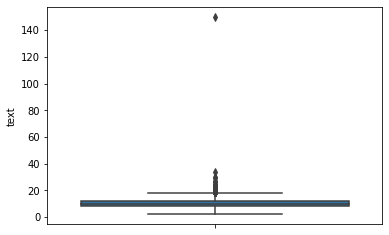

In [ ]:
sns.boxplot(y=df_training['text'].apply(lambda x: str.split(x)).apply(lambda x: len(x))) ## about 20 words per sentence should be okay for padding 


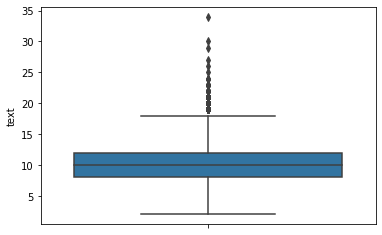

In [ ]:
sns.boxplot(y=df_training['text'].apply(lambda x: str.split(x)).apply(lambda x: len(x) if len(x) < 140 else 10)) ## about 20 words per sentence should be okay for padding 

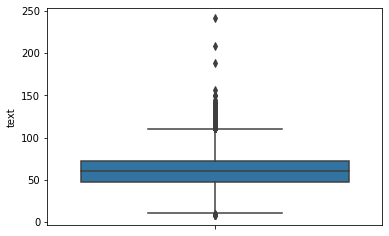

In [ ]:
sns.boxplot(y=df_training['text'].apply(lambda x:  len(x) if len(x) < 800 else 60))

Text(0.5, 1.0, 'Palabras más comunes en frases sarcásticas')

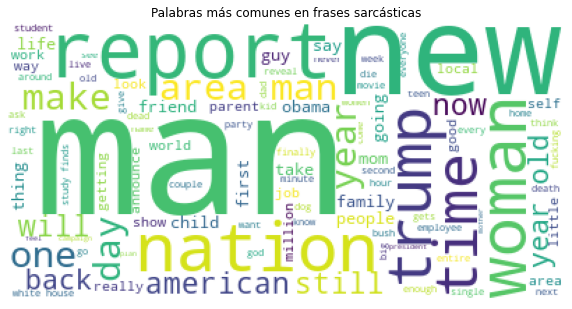

In [ ]:
wc1 = WordCloud(
    background_color='white', 
    max_words=100)

wc1.generate(' '.join(text for text in df_training.loc[df_training['Y'] == 1, 'text']))

plt.figure(figsize=(10,15))
plt.imshow(wc1)
plt.axis('off')
plt.title("Palabras más comunes en frases sarcásticas")

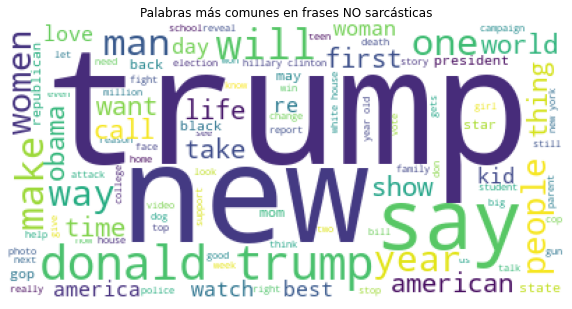

In [ ]:
wc = WordCloud(
    background_color='white', 
    max_words=100)

wc.generate(' '.join(text for text in df_training.loc[df_training['Y'] == 0, 'text']))

plt.figure(figsize=(10,15))
plt.imshow(wc)
plt.axis('off')
plt.title("Palabras más comunes en frases NO sarcásticas")
plt.show()

### Preprocess

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words= stopwords.words('english')

def remove_stopwords(data):
    sentences=[]
    for text in data:
        text = ' '.join(word for word in text.split(' ') if word not in stop_words)
        sentences.append(text)
    return sentences
            

In [ ]:
test_sentences = df_testing['text']
train_sentences = df_training['text']

In [ ]:
test_sentences=[re.sub(r'</?a(?:(?= )[^>]*)?>',' ',frase) for frase in test_sentences]
test_sentences=[re.sub(r'[^\w\s]',' ', frase) for frase in test_sentences] 
test_sentences=[re.sub(r'\n',' ', frase) for frase in test_sentences] 

train_sentences=[re.sub(r'</?a(?:(?= )[^>]*)?>',' ',frase) for frase in train_sentences]
train_sentences=[re.sub(r'[^\w\s]',' ', frase) for frase in train_sentences] 
train_sentences=[re.sub(r'\n',' ', frase) for frase in train_sentences] 

In [ ]:
df= pd.DataFrame()
df['data'] = train_sentences
df['labels'] = df_training['Y']

In [ ]:
y_train=(df_training['Y'])
y_test=(df_testing['Y'])

In [ ]:
num_words=10000

tokenize=Tokenizer(num_words=num_words)

tokenize.fit_on_texts(train_sentences)
x_train=tokenize.texts_to_sequences(train_sentences)
x_test= tokenize.texts_to_sequences(test_sentences)

In [ ]:
max_len = 20

In [ ]:
x_train_pad=pad_sequences(x_train, maxlen= max_len,padding= "post")
x_test_pad=pad_sequences(x_test, maxlen= max_len, padding="post")

#### Definición de arquitecturas

Primero definiremos el modelo más simple el modelo LSTM con un embedding GloVe para agilizar el proceso de entrenamiento. 

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open("/content/drive/MyDrive/TFG/data/glove.6B.100d.txt", encoding='utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [ ]:
vocab_length = len(tokenize.word_index) + 1
vocab_length

22544

In [ ]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in tokenize.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
x_train,x_valid, y_train, y_valid = train_test_split(x_train_pad,y_train)

In [ ]:
epochs = 20 

num_steps = epochs * len(x_train)

#### Red convolucional

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def FCNN_NLP():
    optimizer, lr = transformers.create_optimizer(init_lr  = 2e-3, num_train_steps = num_steps,num_warmup_steps = 0.1*num_steps, weight_decay_rate =.01)



    input = Input(shape=(max_len,))
    net= (Embedding(input_dim= embedding_matrix.shape[0], output_dim= embedding_matrix.shape[1],weights=[embedding_matrix], input_length=max_len))(input)
    net = Dropout(0.2)(net)
    net = BatchNormalization()(net)
    
    net = Conv1D(32, 7, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)
    
    net = Conv1D(1, 1)(net)
    net = GlobalMaxPool1D()(net)
    output = tf.keras.activations.sigmoid(net)
    model = tf.keras.models.Model(inputs = input, outputs = output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),custom_f1])
    return model
model = FCNN_NLP()
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 100)           2254400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 20, 100)           400       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 20, 32)            22432     
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 32)            128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 32)            3104

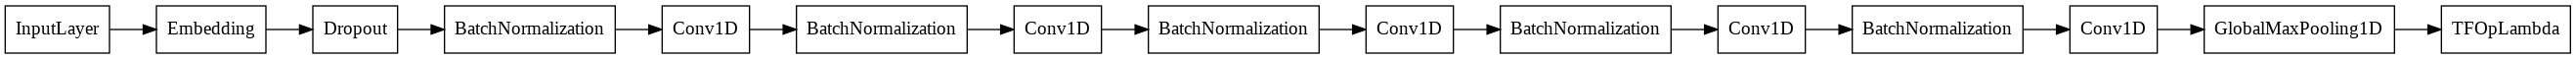

In [ ]:
tf.keras.utils.plot_model(model,show_layer_names=False, rankdir = 'LR')

In [ ]:
batch_size = 32


history = model.fit(x_train, y_train,steps_per_epoch=len(x_train)//batch_size,validation_data=(x_valid,y_valid), validation_steps=len(x_valid)//batch_size
,epochs=50, batch_size=batch_size, callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint("ModelO_FCNN_checkpoint.h5", save_best_weights=True)])

Epoch 1/50
469/469 [==============================] - 24s 46ms/step - loss: 1.4643 - accuracy: 0.4823 - recall_2: 0.9991 - precision_2: 0.4824 - custom_f1: 0.6466 - val_loss: 1.0526 - val_accuracy: 0.4679 - val_recall_2: 1.0000 - val_precision_2: 0.4679 - val_custom_f1: 0.6327
Epoch 2/50
469/469 [==============================] - 18s 38ms/step - loss: 0.9992 - accuracy: 0.4792 - recall_2: 1.0000 - precision_2: 0.4792 - custom_f1: 0.6435 - val_loss: 0.8426 - val_accuracy: 0.4677 - val_recall_2: 0.9996 - val_precision_2: 0.4678 - val_custom_f1: 0.6325
Epoch 3/50
469/469 [==============================] - 15s 32ms/step - loss: 0.8103 - accuracy: 0.4834 - recall_2: 0.9998 - precision_2: 0.4834 - custom_f1: 0.6474 - val_loss: 0.7498 - val_accuracy: 0.4669 - val_recall_2: 0.9974 - val_precision_2: 0.4674 - val_custom_f1: 0.6317
Epoch 4/50
469/469 [==============================] - 15s 32ms/step - loss: 0.7319 - accuracy: 0.4800 - recall_2: 0.9939 - precision_2: 0.4806 - custom_f1: 0.6446 - v

KeyboardInterrupt: ignored

In [ ]:
tf.keras.models.save_model(model, "/content/drive/MyDrive/TFG/models/FCNN_model.h5")

In [ ]:
FCNN_history = history

In [ ]:
FCNN_history.history

#### LSTM

In [ ]:
optimizer, lr = transformers.create_optimizer(init_lr  = 2e-4, num_train_steps = num_steps,num_warmup_steps = 0.1*num_steps, weight_decay_rate =.01)

model= Sequential()
    
model.add(Embedding(input_dim= embedding_matrix.shape[0], output_dim= embedding_matrix.shape[1],weights=[embedding_matrix], input_length=max_len))

model.add(tf.keras.layers.Bidirectional(LSTM(max_len, return_sequences=True))) ## if we were using a GPU backend we should remove recurrent dropout
    
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(max_len, activation="relu"))
model.add(Dense(max_len, activation="relu"))
    
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(max_len, activation="relu"))
    
model.add(Dense(2, activation="softmax"))
    

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],steps_per_execution=32)
  



In [ ]:
tf.keras.utils.plot_model(model,show_layer_names=False, rankdir = 'LR')

In [ ]:
x_train=np.array(x_train)
x_valid=np.array(x_valid)
y_train=np.array(y_train)
y_valid=np.array(y_valid)
x_test_pad= np.array(x_test_pad)
test_labels= np.array(df_testing['Y'])

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_valid,y_valid),epochs=50, batch_size=32, callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint("ModeloLSTM_embedd.h5", save_best_weights=True)])

In [ ]:
tf.keras.models.save_model(model, "/content/drive/MyDrive/TFG/models/LSTM_model.h5")

#### Bert model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
X_train = np.zeros((len(df_training), max_len))
X_masks = np.zeros((len(df_training), max_len))

In [ ]:
for i, text in enumerate(df_training['text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_train[i,:], X_masks[i,:] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
labels = np.array(df_training['Y'])

In [ ]:
with open('X_train.npy','wb') as f:
    np.save(f, X_train)
with open('X_masks.npy','wb') as f:
    np.save(f, X_masks)
with open('labels.npy','wb') as f:
    np.save(f, labels)

In [ ]:
with open('./X_train.npy','rb') as f:
    X_train = np.load(f)
with open('./X_masks.npy','rb') as f:
    X_masks = np.load(f)
with open('./labels.npy','rb') as f:
    labels = np.load(f)

In [ ]:
X_train,X_valid,X_masks_train, X_masks_valid,labels_train,labels_valid = train_test_split(X_train,X_masks,labels)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train,X_masks_train,labels_train))
validation = tf.data.Dataset.from_tensor_slices((X_valid,X_masks_valid,labels_valid))

In [ ]:
def map_func(input_ids, masks , labels):
    return {'input_ids': input_ids, 'attention_mask':masks},labels

In [ ]:
train = train.map(map_func)
validation = validation.map(map_func)

In [ ]:
train = train.shuffle(1000000).batch(32)
validation = validation.shuffle(1000000).batch(32)

In [ ]:
DS_LEN = len(list(train))

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

In [ ]:
input_ids = tf.keras.layers.Input(shape=(max_len,), name = 'input_ids', dtype = 'int32')
mask = tf.keras.layers.Input(shape=(max_len,), name = 'attention_mask', dtype = 'int32')

In [ ]:
embeddings = bert(input_ids, attention_mask = mask)[0]

In [ ]:
epochs = 50

total_steps = DS_LEN * epochs



In [ ]:
####Try to improve this 
X = tf.keras.layers.Bidirectional(GRU(max_len, return_sequences=True))(embeddings)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(32, activation = 'selu')(X)
y = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'outputs')(X)


model = tf.keras.Model(inputs=[input_ids, mask], outputs =y )

model.layers[2].trainable = False

In [ ]:
tf.keras.utils.plot_model(model,show_layer_names=False,rankdir='LR')

In [ ]:
num_steps = epochs * DS_LEN

optimizer, lr = transformers.create_optimizer(init_lr  = 8e-4, num_train_steps = num_steps,num_warmup_steps = 0.1*num_steps, weight_decay_rate =.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [ ]:
history = model.fit(train, validation_data = validation, 
                                        epochs=epochs, batch_size=32, callbacks=[EarlyStopping(patience=5, restore_best_weights=True, min_delta = 0.01), 
                                       ModelCheckpoint("ModeloBert.h5", save_best_weights=True)])



In [ ]:
tf.keras.models.save_model(model, "/content/drive/MyDrive/TFG/models/BERT.h5")

In [ ]:
BERT_history = history

#### DistilBert

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-cased')

model = distilbert

In [ ]:
X_train = np.zeros((len(df_training), max_len))
X_masks = np.zeros((len(df_training), max_len))

In [ ]:
for i, text in enumerate(df_training['text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_train[i,:], X_masks[i,:] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
labels = np.array(df_training['Y'])

In [ ]:
with open('X_train.npy','wb') as f:
    np.save(f, X_train)
with open('X_masks.npy','wb') as f:
    np.save(f, X_masks)
with open('labels.npy','wb') as f:
    np.save(f, labels)

In [ ]:
with open('./X_train.npy','rb') as f:
    X_train = np.load(f)
with open('./X_masks.npy','rb') as f:
    X_masks = np.load(f)
with open('./labels.npy','rb') as f:
    labels = np.load(f)

In [ ]:
X_train_source,X_masks_source,labels_source = X_train,X_masks,labels

In [ ]:
X_train,X_valid,X_masks_train, X_masks_valid,labels_train,labels_valid = train_test_split(X_train,X_masks,labels, train_size = 0.75*prop)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train,X_masks_train,labels_train))
validation = tf.data.Dataset.from_tensor_slices((X_valid,X_masks_valid,labels_valid))

In [ ]:
def map_func(input_ids, masks , labels):
    return {'input_ids': input_ids, 'attention_mask':masks},labels

In [ ]:
train = train.map(map_func)
validation = validation.map(map_func)

In [ ]:
train = train.shuffle(1000000).batch(32)
validation = validation.shuffle(1000000).batch(32)

In [ ]:
DS_LEN = len(list(train))

In [ ]:
input_ids = tf.keras.layers.Input(shape=(max_len,), name = 'input_ids', dtype = 'int32')
mask = tf.keras.layers.Input(shape=(max_len,),name = 'attention_mask', dtype = 'int32')


In [ ]:
embeddings = model(input_ids,attention_mask = mask)[0]




In [ ]:
####Try to improve this 
X = tf.keras.layers.Bidirectional(LSTM(max_len, return_sequences=True))(embeddings)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(32, activation = 'selu')(X)
y = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'outputs')(X)


model = tf.keras.Model(inputs=[input_ids, mask], outputs =y )

model.layers[2].trainable = False

In [ ]:
tf.keras.utils.plot_model(model,show_layer_names=False, rankdir= 'LR')

In [ ]:
epochs = 50

num_steps = epochs * DS_LEN

optimizer, lr = transformers.create_optimizer(init_lr  = 8e-5, num_train_steps = num_steps,num_warmup_steps = 0.1*num_steps, weight_decay_rate =.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
history = model.fit(train, validation_data = validation, 
                                        epochs=epochs, batch_size=32, callbacks=[EarlyStopping(patience=5, restore_best_weights=True), 
                                       ModelCheckpoint("ModeloDistilBert.h5", save_best_weights=True)])

In [ ]:
tf.keras.models.save_model(model, "/content/drive/MyDrive/TFG/models/DistilBert.h5")

In [ ]:
DistilBERT_history = history

### Evaluation

In [ ]:
optimizer, lr = transformers.create_optimizer(init_lr  = 4e-5, num_train_steps = 20,num_warmup_steps = 0.1*20, weight_decay_rate =.01)


In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/TFG/models/FCNN_model.h5', custom_objects={'AdamWeightDecay': optimizer})
model2 = tf.keras.models.load_model('/content/drive/MyDrive/TFG/models/LSTM_model.h5', custom_objects={'AdamWeightDecay': optimizer})
model3 = tf.keras.models.load_model('/content/drive/MyDrive/TFG/models/BERT.h5', custom_objects={"TFBertModel": bert,'AdamWeightDecay': optimizer})
model4 = tf.keras.models.load_model('/content/drive/MyDrive/TFG/models/DistilBert.h5', custom_objects={"TFDistilBertModel": distilbert, 'AdamWeightDecay': optimizer})


#### CNN evaluation

In [ ]:
x = model1.evaluate(x_test_pad,y_test)

In [ ]:
x = pd.DataFrame(x).transpose()

In [ ]:
pd.concat((x,x), axis=0)

#### LSTM evaluation

In [ ]:
model2.evaluate(x_test_pad,y_test)

#### BERT + LSTM evaluation

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
X_test = np.zeros((len(df_testing), max_len))
X_test_masks = np.zeros((len(df_testing), max_len))

for i, text in enumerate(df_testing['text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_test[i,:], X_test_masks[i,:] = tokens['input_ids'], tokens['attention_mask']
    
test_labels = np.array(df_testing['Y'])

with open('X_test.npy','wb') as f:
    np.save(f, X_test)
with open('X_test_masks.npy','wb') as f:
    np.save(f, X_test_masks)
with open('test_labels.npy','wb') as f:
    np.save(f, test_labels)


In [ ]:
with open('./X_test.npy','rb') as f:
    X_test = np.load(f)
with open('./X_test_masks.npy','rb') as f:
    X_test_masks = np.load(f)
with open('./test_labels.npy','rb') as f:
    test_labels = np.load(f)
    
    


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_test,X_test_masks,test_labels))

def map_func(input_ids, masks , labels):
    return {'input_ids': input_ids, 'attention_mask':masks},labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(1000000).batch(32)

In [ ]:
model3.evaluate(dataset)

#### Distilbert + LSTM 

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 

In [ ]:
X_train = np.zeros((len(df_testing), max_len))
X_masks = np.zeros((len(df_testing), max_len))

for i, text in enumerate(df_testing['text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_test[i,:], X_test_masks[i,:] = tokens['input_ids'], tokens['attention_mask']
    
test_labels = np.array(df_testing['Y'])

with open('X_test.npy','wb') as f:
    np.save(f, X_test)
with open('X_test_masks.npy','wb') as f:
    np.save(f, X_test_masks)
with open('test_labels.npy','wb') as f:
    np.save(f, test_labels)

In [ ]:
with open('./X_test.npy','rb') as f:
    X_test = np.load(f)
with open('./X_test_masks.npy','rb') as f:
    X_test_masks = np.load(f)
with open('./test_labels.npy','rb') as f:
    test_labels = np.load(f)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_test,X_test_masks,test_labels))

def map_func(input_ids, masks , labels):
    return {'input_ids': input_ids, 'attention_mask':masks},labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(1000000).batch(32)

In [ ]:
model4.evaluate(dataset)

#### Visualization validation

In [ ]:
F1_FCNN = list(2*np.array(FCNN_history.history['val_precision_6'])*np.array(FCNN_history.history['val_recall_6'])/(np.array(FCNN_history.history['val_precision_6'])+ np.array(FCNN_history.history['val_recall_6'])))

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)


plt.plot(F1_FCNN)
plt.plot(FCNN_history.history['val_accuracy'])
plt.plot(FCNN_history.history['val_precision_6'])
plt.plot(FCNN_history.history['val_recall_6'])
plt.plot(FCNN_history.history['val_loss'])
plt.plot(FCNN_history.history['loss'])
plt.title('FCNN model accuracy')
plt.xlabel('epoch')
plt.legend(["F1",'Precision','Especificidad', 'Sensibilidad','Validación Loss','Training Loss'], loc='lower center')
plt.show()

In [ ]:
F1_LSTM= list(2*np.array(LSTM_history.history['val_precision_10'])*np.array(LSTM_history.history['val_recall_10'])/(np.array(LSTM_history.history['val_precision_10'])+ np.array(LSTM_history.history['val_recall_10'])))

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(F1_LSTM)
plt.plot(LSTM_history.history['val_accuracy'])
plt.plot(LSTM_history.history['val_precision_10'])
plt.plot(LSTM_history.history['val_recall_10'])
plt.plot(LSTM_history.history['val_loss'])
plt.plot(LSTM_history.history['loss'])
plt.title('LSTM model accuracy')
plt.xlabel('epoch')
plt.legend(['F1','Precision','Especificidad', 'Sensibilidad','Validación Loss','Training Loss'], loc='lower center')
plt.show()

In [ ]:
F1_BERT= list(2*np.array(BERT_history.history['val_precision_11'])*np.array(BERT_history.history['val_recall_11'])/(np.array(BERT_history.history['val_precision_11'])+ np.array(BERT_history.history['val_recall_11'])))

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)


plt.plot(F1_BERT)
plt.plot(BERT_history.history['val_accuracy'])
plt.plot(BERT_history.history['val_precision_11'])
plt.plot(BERT_history.history['val_recall_11'])
plt.plot(BERT_history.history['val_loss'])
plt.plot(BERT_history.history['loss'])
plt.title('BERT model accuracy')
plt.xlabel('epoch')
plt.legend(['F1','Precision','Especificidad', 'Sensibilidad','Validación Loss','Training Loss'], loc='lower center')
plt.show()

In [ ]:
F1_distilBERT= list(2*np.array(DistilBERT_history.history['val_precision_12'])*np.array(DistilBERT_history.history['val_recall_12'])/(np.array(DistilBERT_history.history['val_precision_12'])+ np.array(DistilBERT_history.history['val_recall_12'])))

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(F1_distilBERT)
plt.plot(DistilBERT_history.history['val_accuracy'])
plt.plot(DistilBERT_history.history['val_precision_12'])
plt.plot(DistilBERT_history.history['val_recall_12'])
plt.plot(DistilBERT_history.history['val_loss'])
plt.plot(DistilBERT_history.history['loss'])
plt.title('DistilBERT model accuracy')
plt.xlabel('epoch')
plt.legend(['F1','Precision','Especificidad', 'Sensibilidad','Validación Loss','Training Loss'], loc='lower center')
plt.show()

#### Objetivo 80% 

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-cased')

model = distilbert
max_len =20

In [ ]:
X_train = np.zeros((len(df_training), max_len))
X_masks = np.zeros((len(df_training), max_len))

In [ ]:
for i, text in enumerate(df_training['text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_train[i,:], X_masks[i,:] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
labels = np.array(df_training['Y'])

In [ ]:
with open('X_train.npy','wb') as f:
    np.save(f, X_train)
with open('X_masks.npy','wb') as f:
    np.save(f, X_masks)
with open('labels.npy','wb') as f:
    np.save(f, labels)

In [ ]:
with open('./X_train.npy','rb') as f:
    X_train = np.load(f)
with open('./X_masks.npy','rb') as f:
    X_masks = np.load(f)
with open('./labels.npy','rb') as f:
    labels = np.load(f)

In [ ]:
X_test = np.zeros((len(df_testing), max_len))
X_test_masks = np.zeros((len(df_testing), max_len))

for i, text in enumerate(df_testing['text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_test[i,:], X_test_masks[i,:] = tokens['input_ids'], tokens['attention_mask']
    
test_labels = np.array(df_testing['Y'])

with open('X_test.npy','wb') as f:
    np.save(f, X_test)
with open('X_test_masks.npy','wb') as f:
    np.save(f, X_test_masks)
with open('test_labels.npy','wb') as f:
    np.save(f, test_labels)

In [ ]:
with open('./X_test.npy','rb') as f:
    X_test = np.load(f)
with open('./X_test_masks.npy','rb') as f:
    X_test_masks = np.load(f)
with open('./test_labels.npy','rb') as f:
    test_labels = np.load(f)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,X_test_masks,test_labels))

def map_func(input_ids, masks , labels):
    return {'input_ids': input_ids, 'attention_mask':masks},labels

test_dataset = test_dataset.map(map_func)
test_dataset = test_dataset.shuffle(1000000).batch(32)

In [ ]:
X_train_source = X_train
X_masks_source = X_masks
labels_source = labels

In [ ]:
results = [0,0,0,0]
results = pd.DataFrame(results).transpose()

for prop in [0.05,0.3,0.6, 0.8,1]:
  X_train,X_valid,X_masks_train, X_masks_valid,labels_train,labels_valid = train_test_split(X_train_source,X_masks_source,labels_source, train_size = 0.75*prop)

  train = tf.data.Dataset.from_tensor_slices((X_train,X_masks_train,labels_train))
  validation = tf.data.Dataset.from_tensor_slices((X_valid,X_masks_valid,labels_valid))

  def map_func(input_ids, masks , labels):
      return {'input_ids': input_ids, 'attention_mask':masks},labels

  train = train.map(map_func)
  validation = validation.map(map_func)

  train = train.shuffle(1000000).batch(32)
  validation = validation.shuffle(1000000).batch(32)

  DS_LEN = len(list(train))

  input_ids = tf.keras.layers.Input(shape=(max_len,), name = 'input_ids', dtype = 'int32')
  mask = tf.keras.layers.Input(shape=(max_len,),name = 'attention_mask', dtype = 'int32')

  embeddings = distilbert(input_ids,attention_mask = mask)[0]


  ####Try to improve this 
  X = tf.keras.layers.Bidirectional(LSTM(max_len, return_sequences=True))(embeddings)
  X = tf.keras.layers.Dense(128, activation = 'selu')(X)
  X = tf.keras.layers.GlobalMaxPool1D()(X)
  X = tf.keras.layers.Dense(128, activation = 'selu')(X)
  X = tf.keras.layers.Dropout(0.3)(X)
  X = tf.keras.layers.Dense(128, activation = 'selu')(X)
  X = tf.keras.layers.Dropout(0.3)(X)
  X = tf.keras.layers.Dense(32, activation = 'selu')(X)
  y = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'outputs')(X)


  model = tf.keras.Model(inputs=[input_ids, mask], outputs =y )

  model.layers[2].trainable = False


  epochs = 20

  num_steps = epochs * DS_LEN

  optimizer, lr = transformers.create_optimizer(init_lr  = 4e-5, num_train_steps = num_steps,num_warmup_steps = 0.1*num_steps, weight_decay_rate =.01)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


  model.fit(train, validation_data = validation, 
                                          epochs=epochs, batch_size=32, callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
                                        ModelCheckpoint("ModeloDistilBert.h5", save_best_weights=True)])

  x = model.evaluate(test_dataset)
     
  x = pd.DataFrame(x).transpose()

  results = pd.concat((results,x), axis=0)


In [ ]:
results = results.iloc[1:,]

results.columns = ['Loss','Precision','Sensibilidad','Especificidad']

In [ ]:
results['Proporcion'] = [0.05,0.3,0.6, 0.8,1]

In [ ]:
results['F1'] = (2*results['Especificidad']*results['Sensibilidad'])/(results['Especificidad']+results['Sensibilidad'])

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)


plt.plot(results['F1'])
plt.plot(results['Precision'])
plt.plot(results['Especificidad'])
plt.plot(results['Sensibilidad'])
plt.plot(results['Loss'])
plt.title('Model accuracy by proportion Database')
plt.legend(["F1",'Precision','Especificidad', 'Sensibilidad','Loss'], loc='Best')
plt.show()